In [1]:
from pyspark.sql import SQLContext, Window
from pyspark.sql.functions import *
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from  pyspark.sql.functions import abs, sqrt
import pyspark.sql.functions as sf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#mean_length=1
#2 rows are calculated
df1= sqlContext.sql("SELECT aapl.date, aapl.close, max(aapl.close) OVER ( ORDER BY CAST(date as timestamp) RANGE BETWEEN INTERVAL 2 DAYS PRECEDING AND CURRENT ROW) AS max FROM aapl WHERE YEAR(aapl.date) BETWEEN 2000 AND 2010")
df1.show()

+-------------------+--------+--------+
 date| close| max|
+-------------------+--------+--------+
2000-01-03 00:00:00|3.553571|3.553571|
2000-01-10 00:00:00|3.587054|3.587054|
2000-01-17 00:00:00|3.975446|3.975446|
2000-01-24 00:00:00|3.629464|3.629464|
2000-01-31 00:00:00|3.857143|3.857143|
2000-02-07 00:00:00|3.883929|3.883929|
2000-02-14 00:00:00|3.973214|3.973214|
2000-02-21 00:00:00|3.941964|3.941964|
2000-02-28 00:00:00|4.571429|4.571429|
2000-03-06 00:00:00|4.491071|4.491071|
2000-03-13 00:00:00|4.464286|4.464286|
2000-03-20 00:00:00|4.953125|4.953125|
2000-03-27 00:00:00|4.850446|4.850446|
2000-04-03 00:00:00|4.705357|4.705357|
2000-04-10 00:00:00|3.995536|3.995536|
2000-04-17 00:00:00|4.245536|4.245536|
2000-04-24 00:00:00|4.430804|4.430804|
2000-05-01 00:00:00|4.040179|4.040179|
2000-05-08 00:00:00| 3.84375| 3.84375|
2000-05-15 00:00:00|3.357143|3.357143|
+-------------------+--------+--------+
only showing top 20 rows

In [3]:
def get_mean_lag(lags):
  df0 = sqlContext.sql("SELECT aapl.date, aapl.low,aapl.high, aapl.close,mean(aapl.close) OVER ( ORDER BY CAST(date as timestamp) RANGE BETWEEN INTERVAL {} DAYS PRECEDING AND CURRENT ROW) AS mean,min(aapl.close) OVER ( ORDER BY CAST(date as timestamp) RANGE BETWEEN INTERVAL {} DAYS PRECEDING AND CURRENT ROW) AS min,max(aapl.close) OVER ( ORDER BY CAST(date as timestamp) RANGE BETWEEN INTERVAL {} DAYS PRECEDING AND CURRENT ROW) AS max FROM aapl WHERE YEAR(aapl.date) BETWEEN 2000 AND 2010".format(lags,lags,lags))
  partitionwindow = Window.orderBy("date")
  lagtest = lag("close",lags,0).over(partitionwindow)
  df = df0.withColumn("lag{}".format(lags),lagtest)
  
  lagtest = lag("close",2*lags,0).over(partitionwindow)
  df = df.withColumn("lag{}".format(2*lags),lagtest)
  lagtest = lag("high",lags,0).over(partitionwindow)
  df = df.withColumn("high_lag{}".format(lags),lagtest)
  lagtest = lag("low",lags,0).over(partitionwindow)
  df = df.withColumn("low_lag{}".format(lags),lagtest)
  partitionwindow = Window.orderBy("date")
  df=df.withColumn("index", monotonically_increasing_id())
  lagtest = lag("mean",lags,0).over(partitionwindow)
  df = df.withColumn("mean_lag".format(lags),lagtest)
  lagtest = lag("max",lags,0).over(partitionwindow)
  df = df.withColumn("max_lag".format(lags),lagtest)
  lagtest = lag("min",lags,0).over(partitionwindow)
  df = df.withColumn("min_lag".format(lags),lagtest)
  
  df = df.withColumn("close_log",log(df["close"]))
  df = df.withColumn("lag{}_log".format(lags),log(df["lag{}".format(lags)]))
  df = df.withColumn("lag{}_log".format(2*lags),log(df["lag{}".format(2*lags)]))
  df = df.withColumn("high_lag{}_log".format(lags),log(df["high_lag{}".format(lags)]))
  df = df.withColumn("low_lag{}_log".format(lags),log(df["low_lag{}".format(lags)]))
  df = df.withColumn("mean_lag_log",log(df["mean_lag"]))
  df = df.withColumn("max_lag_log",log(df["max_lag".format(lags)]))
  df = df.withColumn("min_lag_log",log(df["min_lag".format(lags)]))
  
  df=df.filter(df["index"]>=2*lags+1)
  df=df.where("lag{}!=0".format(2*lags))
  
  df = df.select("index","close_log","lag{}_log".format(lags),"lag{}_log".format(2*lags),"high_lag{}_log".format(lags),"low_lag{}_log".format(lags),"mean_lag_log","max_lag_log","min_lag_log")
  return df

In [4]:
df_daily = get_mean_lag(1)
df_daily.show()

+-----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
index| close_log| lag1_log| lag2_log| high_lag1_log| low_lag1_log| mean_lag_log| max_lag_log| min_lag_log|
+-----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
 3|1.2890849789719805|1.3801369430700665|1.2773312527998073|1.4677098184490185|1.2773312527998073|1.3801369430700665|1.3801369430700665|1.3801369430700665|
 4|1.3499267539860522|1.2890849789719805|1.3801369430700665|1.4056373239630215|1.2791962255635234|1.2890849789719805|1.2890849789719805|1.2890849789719805|
 5| 1.356847270138411|1.3499267539860522|1.2890849789719805|1.3682757465262971|1.2163953243244932|1.3499267539860522|1.3499267539860522|1.3499267539860522|
 6|1.3795753389610308| 1.356847270138411|1.3499267539860522| 1.431037298686475|1.3306447496414526| 1.356847270138411| 1.356847270138411| 1.356847270138411|
 7|1.3716790762687363|1.3795753389610308| 1.356847270138411|1.4547662302420108|1.3556969997624784|1.3795753389610308|1.3795753389610308|1.3795753389610308|
 8|1.5198258474944089|1.3716790762687363|1.3795753389610308|1.4479687846428115| 1.337699527872132|1.3716790762687363|1.3716790762687363|1.3716790762687363|
 9|1.5020912033772047|1.5198258474944089|1.3716790762687363|1.5510708154897601|1.3533929987432616|1.5198258474944089|1.5198258474944089|1.5198258474944089|
 10|1.4961092911270952|1.5020912033772047|1.5198258474944089|1.5285763862868635| 1.440596449543559|1.5020912033772047|1.5020912033772047|1.5020912033772047|
 11|1.6000186905176088|1.4961092911270952|1.5020912033772047|1.5080377663718172|1.4039940434824438|1.4961092911270952|1.4961092911270952|1.4961092911270952|
 12|1.5790706594843305|1.6000186905176088|1.4961092911270952|1.6809277173199701|1.4687380303309652|1.6000186905176088|1.6000186905176088|1.6000186905176088|
 13| 1.548701646885736|1.5790706594843305|1.6000186905176088|1.6428036339117518|1.4996031801581322|1.5790706594843305|1.5790706594843305|1.5790706594843305|
 14|1.3851777379281929| 1.548701646885736|1.5790706594843305| 1.605860119760051| 1.427830420635044| 1.548701646885736| 1.548701646885736| 1.548701646885736|
 15|1.4458680779879298|1.3851777379281929| 1.548701646885736| 1.55626305955136|1.3205647308934507|1.3851777379281929|1.3851777379281929|1.3851777379281929|
 16|1.4885810574317417|1.4458680779879298|1.3851777379281929| 1.537251231878616|1.3597165288691042|1.4458680779879298|1.4458680779879298|1.4458680779879298|
 17|1.3962889979222288|1.4885810574317417|1.4458680779879298|1.5256679672327174|1.4105512690486726|1.4885810574317417|1.4885810574317417|1.4885810574317417|
 18| 1.346448452572691|1.3962889979222288|1.4885810574317417|1.5060596530297659|1.3733765341020614|1.3962889979222288|1.3962889979222288|1.3962889979222288|
 19|1.2110903146479906| 1.346448452572691|1.3962889979222288|1.4012489812873035|1.2603869746186822| 1.346448452572691| 1.346448452572691| 1.346448452572691|
 20| 1.126493632983532|1.2110903146479906| 1.346448452572691|1.3597165288691042|1.2044190047637129|1.2110903146479906|1.2110903146479906|1.2110903146479906|
 21| 1.195679711494939| 1.126493632983532|1.2110903146479906|1.2084270693419794|1.0866361940069316| 1.126493632983532| 1.126493632983532| 1.126493632983532|
 22|1.2295361596610075| 1.195679711494939| 1.126493632983532| 1.270462545594769|1.0544987719160115| 1.195679711494939| 1.195679711494939| 1.195679711494939|
+-----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
only showing top 20 rows

In [5]:
def pre_process(df,lags):
  #df = df.select("lag{}".format(lags),"lag{}".format(2*lags),"mean_lag","max_lag","min_lag","high_lag{}".format(lags),"low_lag{}".format(lags),"close")
  featureassembler = VectorAssembler(inputCols=["close_log","lag{}_log".format(lags),"lag{}_log".format(2*lags),"high_lag{}_log".format(lags),"low_lag{}_log".format(lags),"mean_lag_log","max_lag_log","min_lag_log"],outputCol="features")
  output = featureassembler.transform(df)
  finalized_data = output.select("features","close_log")
  return finalized_data

In [6]:
df_daily_pre_process = pre_process(df_daily,1)
df_daily_pre_process.show()

+--------------------+------------------+
 features| close_log|
+--------------------+------------------+
[1.28908497897198...|1.2890849789719805|
[1.34992675398605...|1.3499267539860522|
[1.35684727013841...| 1.356847270138411|
[1.37957533896103...|1.3795753389610308|
[1.37167907626873...|1.3716790762687363|
[1.51982584749440...|1.5198258474944089|
[1.50209120337720...|1.5020912033772047|
[1.49610929112709...|1.4961092911270952|
[1.60001869051760...|1.6000186905176088|
[1.57907065948433...|1.5790706594843305|
[1.54870164688573...| 1.548701646885736|
[1.38517773792819...|1.3851777379281929|
[1.44586807798792...|1.4458680779879298|
[1.48858105743174...|1.4885810574317417|
[1.39628899792222...|1.3962889979222288|
[1.34644845257269...| 1.346448452572691|
[1.21109031464799...|1.2110903146479906|
[1.12649363298353...| 1.126493632983532|
[1.19567971149493...| 1.195679711494939|
[1.22953615966100...|1.2295361596610075|
+--------------------+------------------+
only showing top 20 rows

In [7]:
def model_training(df,train_ratio):
  dt_reg = DecisionTreeRegressor
  train_data,test_data = df.randomSplit([train_ratio,1-train_ratio])
  regressor = dt_reg(featuresCol="features",labelCol="close_log")
  regressor = regressor.fit(train_data)
  pred_results = regressor.transform(test_data)
  
  return pred_results,regressor.featureImportances

In [8]:
pre_results_daily,feature_impotance_daily = model_training(df_daily_pre_process,0.7)
print(feature_impotance_daily)
pre_results_daily.show()

(8,[0,1,2,3],[0.998755888558,3.26428749308e-05,0.000922534131298,0.000288934435663])
+--------------------+--------------------+--------------------+
 features| close_log| prediction|
+--------------------+--------------------+--------------------+
[-0.0649193936603...|-0.06491939366030292|0.001383629201928...|
[0.01206986523058...|0.012069865230580918|0.001383629201928...|
[0.03578115078867...| 0.03578115078867798| 0.06914449528295573|
[0.04674712620697...| 0.04674712620697081| 0.06914449528295573|
[0.05015019129408...|0.050150191294084094| 0.06914449528295573|
[0.06230415179249...| 0.06230415179249471| 0.06914449528295573|
[0.11651200601811...| 0.11651200601811011| 0.06914449528295573|
[0.11651200601811...| 0.11651200601811011| 0.06914449528295573|
[0.14224320931079...| 0.14224320931079917| 0.2004294537956874|
[0.18529297109996...| 0.18529297109996262| 0.2004294537956874|
[0.25519555362748...| 0.25519555362748153| 0.28699440103159934|
[0.26784383952172...| 0.26784383952172813| 0.28699440103159934|
[0.26893570211975...| 0.26893570211975487| 0.28699440103159934|
[0.28249036885108...| 0.28249036885108075| 0.28699440103159934|
[0.28786030656713...| 0.28786030656713735| 0.28699440103159934|
[0.29479943383766...| 0.2947994338376605| 0.28699440103159934|
[0.30380145433166...| 0.3038014543316642| 0.28699440103159934|
[0.30538175481433...| 0.3053817548143342| 0.28699440103159934|
[0.31193873637180...| 0.31193873637180153| 0.36607782257391136|
[0.31845373111853...| 0.3184537311185346| 0.36607782257391136|
+--------------------+--------------------+--------------------+
only showing top 20 rows

In [9]:

def smape(Close, Prediction):
    return 100/len(Close) * np.sum(2 * np.abs(Prediction - Close) / (np.abs(Close) + np.abs(Prediction)))

def rmse(A, B):
    return np.sqrt(((A - B) ** 2).mean())


In [10]:
def get_metrice(pred_results):
  pred_results = pred_results.withColumn("squared_error",pow((col("close_log") - col("prediction")),2))
  Prediction = np.array(pred_results.select('prediction').rdd.map(lambda row : row[0]).collect())
  Close = np.array(pred_results.select('close_log').rdd.map(lambda row : row[0]).collect())
  return smape(Close, Prediction),rmse(Prediction,Close)

In [11]:
smape_daliy,rmse_daily = get_metrice(pre_results_daily)
print(smape_daliy)
print(rmse_daily)

7.22383639246
0.0511835673393

In [12]:
def plot_result(pred_results):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(pred_results.select('close_log').rdd.map(lambda row : row[0]).collect(), label='Close Price')
  ax.plot(pred_results.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
  plt.legend()
  display(fig)

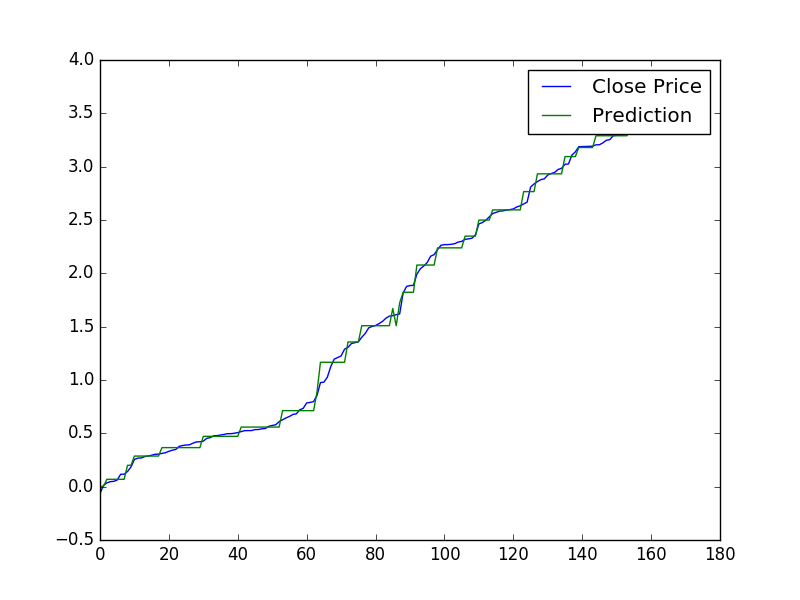

In [13]:
plot_result(pre_results_daily)

In [14]:
# daily is above

In [15]:
# weekly
df_weekly = get_mean_lag(5)
df_weekly_pre_process = pre_process(df_weekly,5)
pre_results_weekly,feature_impotance_weekly = model_training(df_weekly_pre_process,0.7)
print(feature_impotance_weekly)
smape_weekly,rmse_weekly = get_metrice(pre_results_weekly)
print(smape_weekly)
print(rmse_weekly)


(8,[0,1,2,4],[0.999631864986,0.000160088202991,0.000180231136744,2.78156744179e-05])
7.8151186377
0.0521000919143

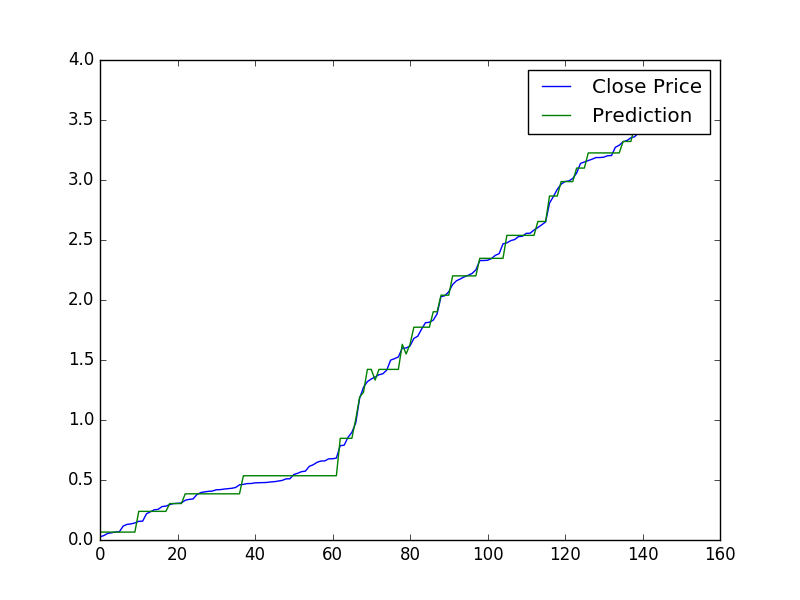

In [16]:
plot_result(pre_results_weekly)

In [17]:
# biweekly
df_biweekly = get_mean_lag(5)
df_biweekly_pre_process = pre_process(df_biweekly,5)
pre_results_biweekly,feature_impotance_biweekly = model_training(df_biweekly_pre_process,0.7)
print(feature_impotance_biweekly)
smape_biweekly,rmse_biweekly = get_metrice(pre_results_biweekly)
print(smape_biweekly)
print(rmse_biweekly)

(8,[0,1,2,3,4],[0.999351391826,0.000588881869797,1.75324544941e-05,4.13900531655e-06,3.80548444611e-05])
7.37549040061
0.0452317356011

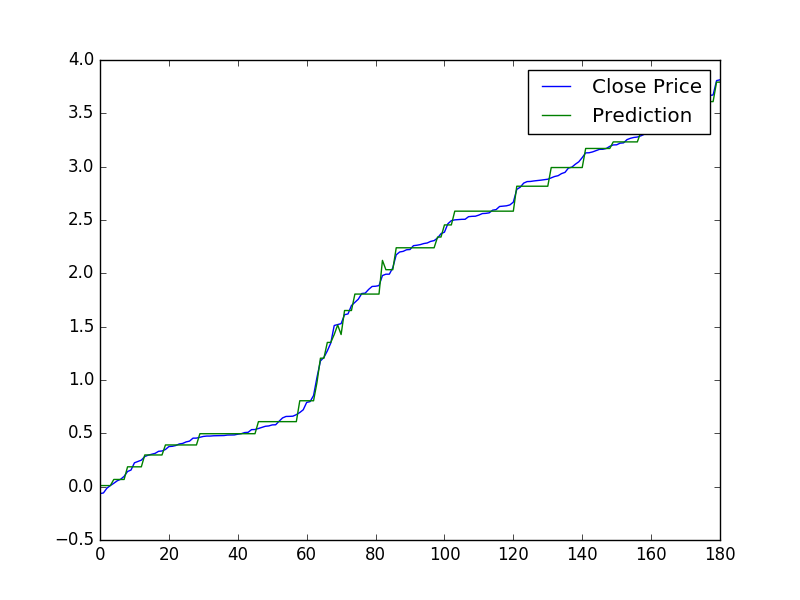

In [18]:
plot_result(pre_results_biweekly)

In [19]:
# month

In [20]:
df_month = get_mean_lag(21)
df_month_pre_process = pre_process(df_month,21)
pre_results_month,feature_impotance_month = model_training(df_month_pre_process,0.7)
print(feature_impotance_month)
smape_month,rmse_month = get_metrice(pre_results_month)
print(smape_month)
print(rmse_month)

(8,[0,1,2,4,5,7],[0.986073693447,0.000116461342144,0.00208149035601,0.00385784292177,2.23379574438e-05,0.00784817397513])
9.06888854088
0.0591722440035

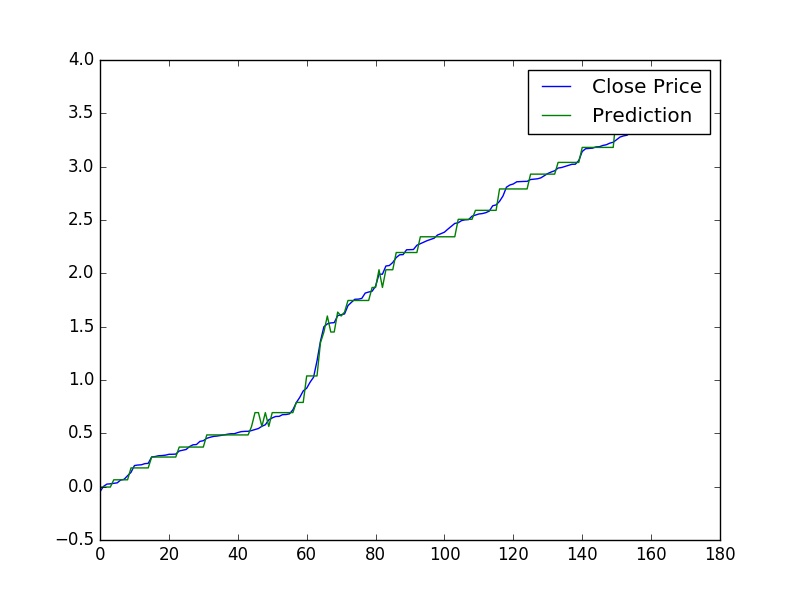

In [21]:
plot_result(pre_results_month)

In [22]:
#3month
df_4month = get_mean_lag(63)
df_4month_pre_process = pre_process(df_4month,63)
pre_results_4month,feature_impotance_4month = model_training(df_4month_pre_process,0.7)
print(feature_impotance_4month)
smape_4month,rmse_4month = get_metrice(pre_results_4month)
print(smape_4month)
print(rmse_4month)

(8,[0,1,2,3,4,6],[0.993621357826,1.16232719538e-07,0.00409307363787,8.96162613135e-05,0.000292210389988,0.00190362565192])
9.52580404678
0.0553015184852

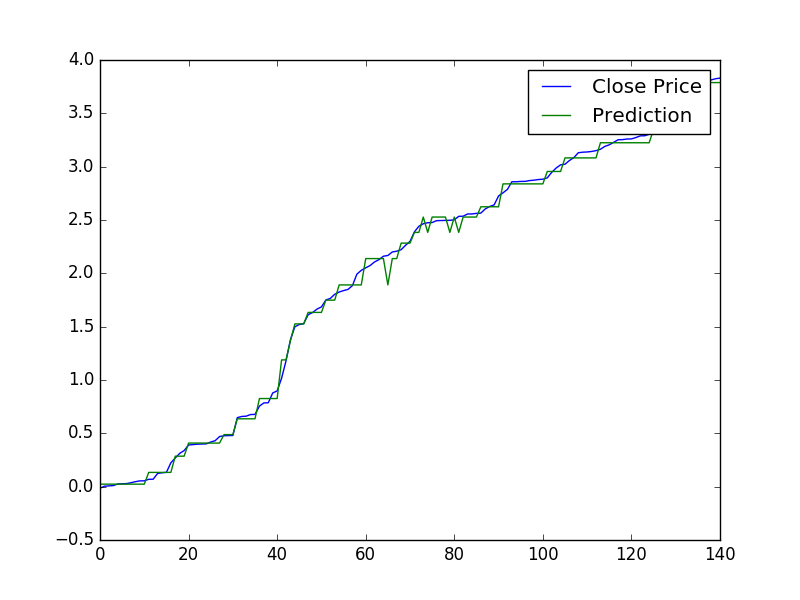

In [23]:
plot_result(pre_results_4month)